In [1]:
# Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
import os
from PIL import Image

In [2]:
def load_cifake_data(data_path):
    """Load CIFAKE dataset from test set"""
    real_images = []
    fake_images = []
    
    # Load real images from test set
    real_path = os.path.join(data_path, 'test', 'REAL')
    for img_file in os.listdir(real_path):
        img = Image.open(os.path.join(real_path, img_file))
        real_images.append(np.array(img))
    
    # Load fake images from test set
    fake_path = os.path.join(data_path, 'test', 'FAKE')
    for img_file in os.listdir(fake_path):
        img = Image.open(os.path.join(fake_path, img_file))
        fake_images.append(np.array(img))
    
    # Create labels (0 = REAL, 1 = FAKE)
    X = np.array(real_images + fake_images)
    y = np.array([0] * len(real_images) + [1] * len(fake_images))
    
    # Normalize pixel values to 0-1 range
    X = X.astype('float32') / 255.0
    
    # Flatten images for traditional ML algorithms
    X_flattened = X.reshape(X.shape[0], -1)
    
    return X, X_flattened, y

In [3]:
# Set data path to CIFAKE directory
data_path = os.path.join(os.getcwd(), 'data', 'CIFAKE')

# Load and split data
X, X_flat, y = load_cifake_data(data_path)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42, stratify=y)

# For neural networks, keep original shape
X_train_cnn, X_test_cnn, _, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
from sklearn.linear_model import LogisticRegression

# Implementation
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Evaluation
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 0.6555


In [5]:
from sklearn.neighbors import KNeighborsClassifier

# Try different k values
k_values = [3, 5, 7, 9, 11]
best_k = 5  # You can optimize this

knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

In [6]:
from sklearn.svm import SVC

# Use RBF kernel
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

In [7]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

In [8]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [11]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)
ada_pred = ada_model.predict(X_test)

In [12]:
# Using Keras/TensorFlow
mlp_model = Sequential([
    Dense(512, activation='relu', input_shape=(3072,)),  # 32*32*3 = 3072
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
mlp_pred = (mlp_model.predict(X_test) > 0.5).astype(int).flatten()

C:\Users\sniki\OneDrive\Desktop\RealorAI\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1/125 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step

 19/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

 37/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 75/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

110/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [13]:
def evaluate_model(y_true, y_pred, model_name):
    """Comprehensive evaluation function"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

In [14]:
# Create comparison dataframe
results = []
results.append(evaluate_model(y_test, lr_pred, 'Logistic Regression'))
results.append(evaluate_model(y_test, knn_pred, 'KNN'))
results.append(evaluate_model(y_test, svm_pred, 'SVM'))
results.append(evaluate_model(y_test, nb_pred, 'Naive Bayes'))
results.append(evaluate_model(y_test, dt_pred, 'Decision Tree'))
results.append(evaluate_model(y_test, rf_pred, 'Random Forest'))
results.append(evaluate_model(y_test, xgb_pred, 'XGBoost'))
results.append(evaluate_model(y_test, ada_pred, 'AdaBoost'))
results.append(evaluate_model(y_test, mlp_pred, 'MLP'))

results_df = pd.DataFrame(results)

In [15]:
# Display Results DataFrame
print("="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print("\nDetailed Performance Metrics:\n")
print(results_df.to_string(index=False))
print("\n" + "="*80)

MODEL COMPARISON RESULTS

Detailed Performance Metrics:

              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression   0.65550   0.658189  0.6470  0.652547
                KNN   0.66175   0.701558  0.5630  0.624688
                SVM   0.81050   0.811434  0.8090  0.810215
        Naive Bayes   0.60500   0.594680  0.6595  0.625415
      Decision Tree   0.67550   0.727038  0.5620  0.633954
      Random Forest   0.80400   0.794574  0.8200  0.807087
            XGBoost   0.81425   0.814093  0.8145  0.814296
           AdaBoost   0.70675   0.706440  0.7075  0.706970
                MLP   0.74275   0.773830  0.6860  0.727273



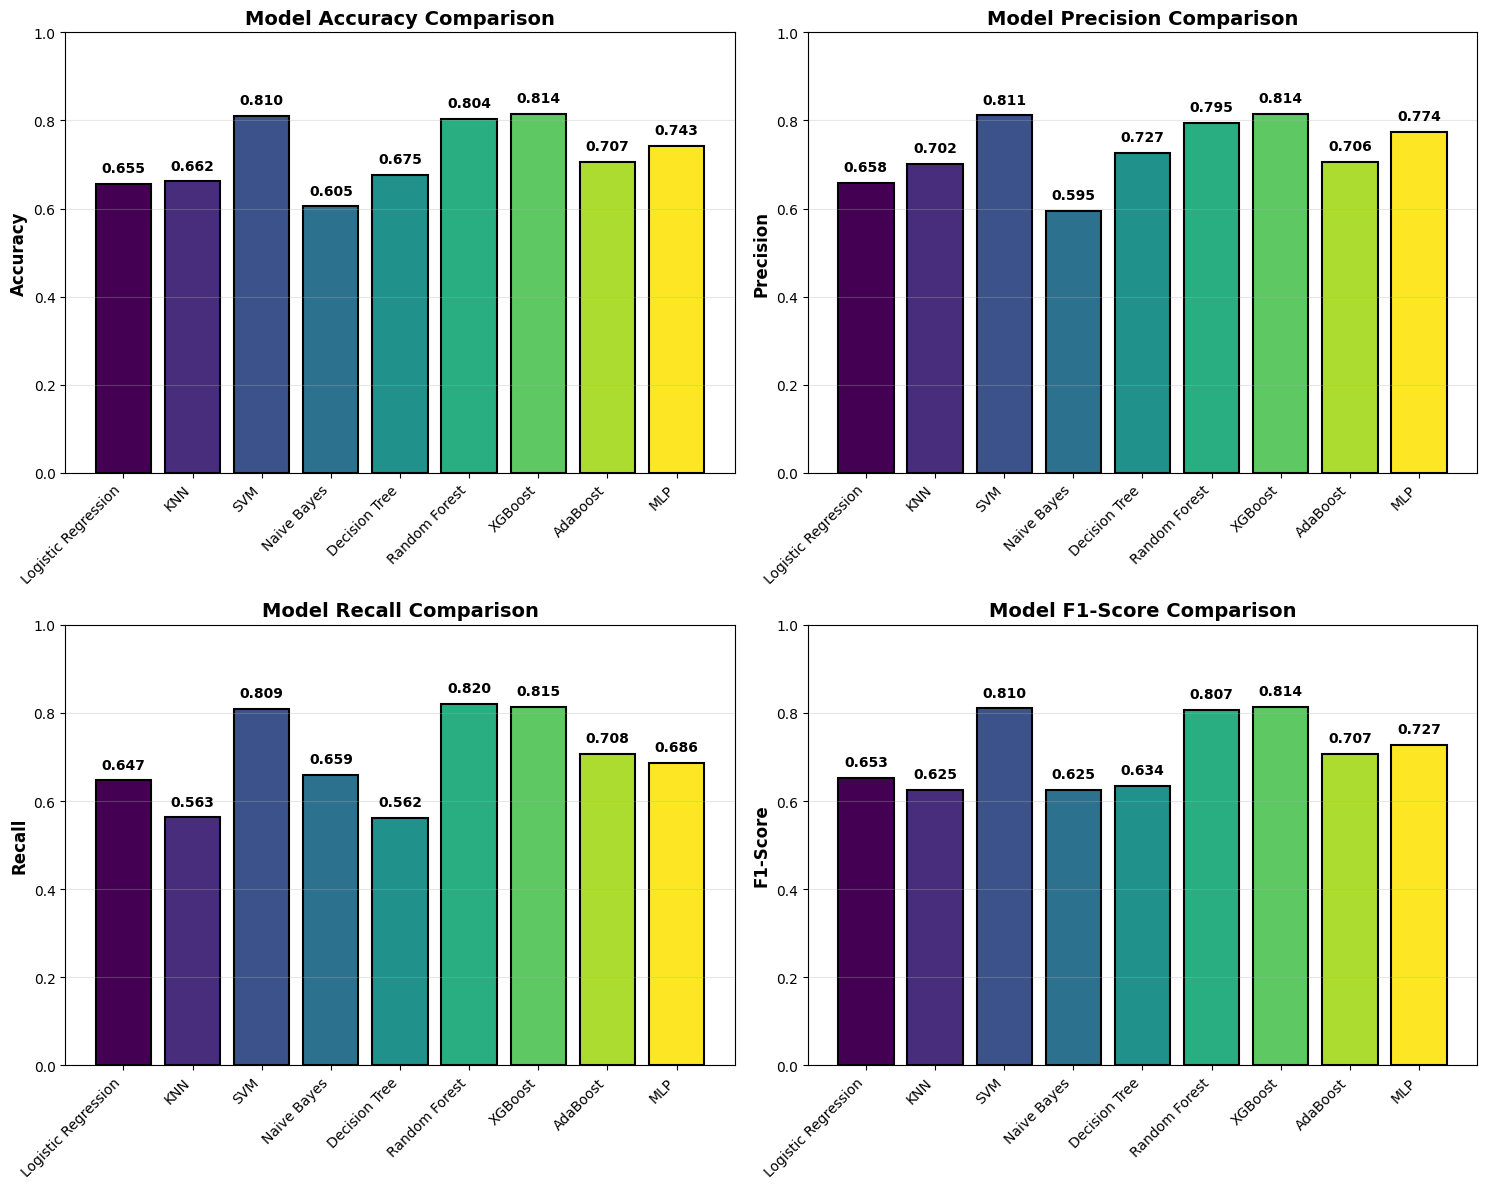


✅ Visualizations displayed successfully!


In [16]:
# Visualize Model Accuracies
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy Comparison Bar Chart
ax1 = axes[0, 0]
models = results_df['Model'].values
accuracies = results_df['Accuracy'].values
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
bars = ax1.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Precision Comparison
ax2 = axes[0, 1]
precisions = results_df['Precision'].values
bars = ax2.bar(models, precisions, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.set_title('Model Precision Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
for i, (bar, prec) in enumerate(zip(bars, precisions)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{prec:.3f}', ha='center', va='bottom', fontweight='bold')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Recall Comparison
ax3 = axes[1, 0]
recalls = results_df['Recall'].values
bars = ax3.bar(models, recalls, color=colors, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax3.set_title('Model Recall Comparison', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)
for i, (bar, rec) in enumerate(zip(bars, recalls)):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{rec:.3f}', ha='center', va='bottom', fontweight='bold')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. F1-Score Comparison
ax4 = axes[1, 1]
f1_scores = results_df['F1-Score'].values
bars = ax4.bar(models, f1_scores, color=colors, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax4.set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
ax4.set_ylim([0, 1])
ax4.grid(axis='y', alpha=0.3)
for i, (bar, f1) in enumerate(zip(bars, f1_scores)):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n✅ Visualizations displayed successfully!")

In [17]:
# Best Model Summary
print("\n" + "="*80)
print("🏆 BEST MODEL ANALYSIS")
print("="*80)

# Find best model by each metric
best_accuracy_idx = results_df['Accuracy'].idxmax()
best_precision_idx = results_df['Precision'].idxmax()
best_recall_idx = results_df['Recall'].idxmax()
best_f1_idx = results_df['F1-Score'].idxmax()

print(f"\n🥇 Best Accuracy: {results_df.loc[best_accuracy_idx, 'Model']}")
print(f"   Score: {results_df.loc[best_accuracy_idx, 'Accuracy']:.4f}")

print(f"\n🥇 Best Precision: {results_df.loc[best_precision_idx, 'Model']}")
print(f"   Score: {results_df.loc[best_precision_idx, 'Precision']:.4f}")

print(f"\n🥇 Best Recall: {results_df.loc[best_recall_idx, 'Model']}")
print(f"   Score: {results_df.loc[best_recall_idx, 'Recall']:.4f}")

print(f"\n🥇 Best F1-Score: {results_df.loc[best_f1_idx, 'Model']}")
print(f"   Score: {results_df.loc[best_f1_idx, 'F1-Score']:.4f}")

# Overall best model (by accuracy)
overall_best = results_df.loc[best_accuracy_idx]
print(f"\n{'='*80}")
print(f"✨ OVERALL BEST MODEL: {overall_best['Model']}")
print(f"{'='*80}")
print(f"Accuracy:  {overall_best['Accuracy']:.4f}")
print(f"Precision: {overall_best['Precision']:.4f}")
print(f"Recall:    {overall_best['Recall']:.4f}")
print(f"F1-Score:  {overall_best['F1-Score']:.4f}")
print(f"{'='*80}\n")


🏆 BEST MODEL ANALYSIS

🥇 Best Accuracy: XGBoost
   Score: 0.8143

🥇 Best Precision: XGBoost
   Score: 0.8141

🥇 Best Recall: Random Forest
   Score: 0.8200

🥇 Best F1-Score: XGBoost
   Score: 0.8143

✨ OVERALL BEST MODEL: XGBoost
Accuracy:  0.8143
Precision: 0.8141
Recall:    0.8145
F1-Score:  0.8143



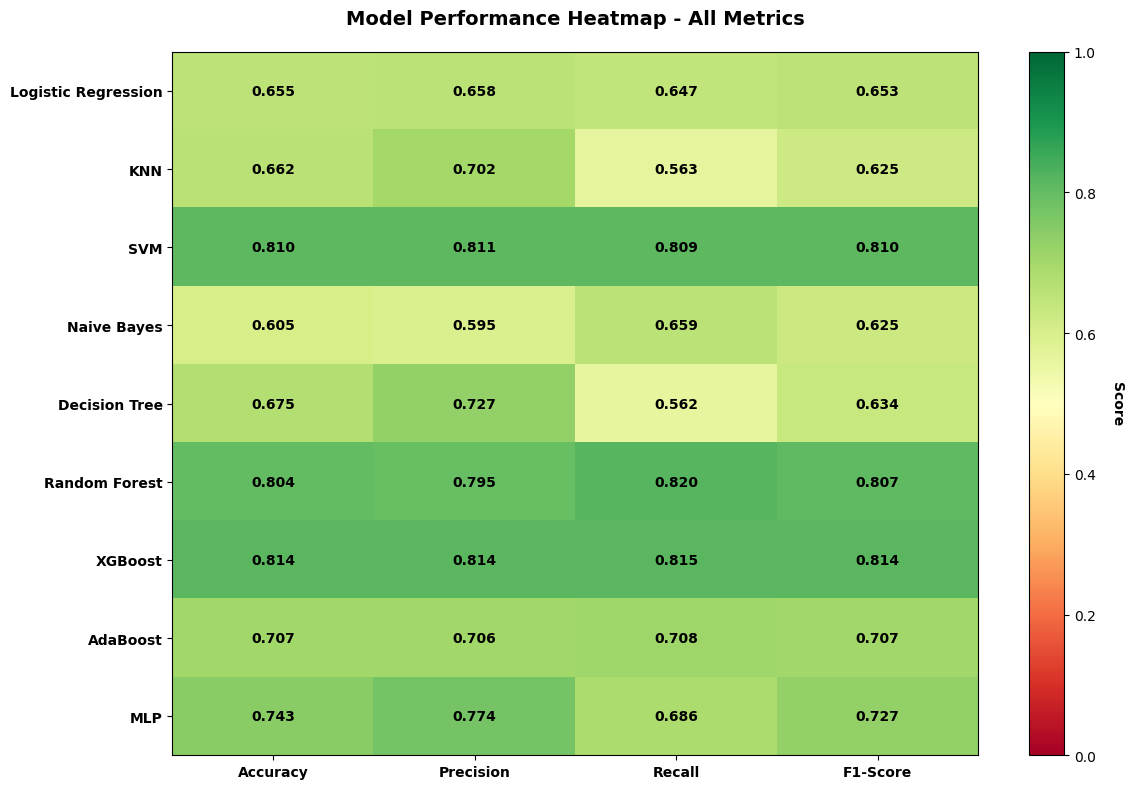

✅ Heatmap visualization displayed!


In [18]:
# Create a detailed heatmap of all metrics
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].values

# Create heatmap
im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(['Accuracy', 'Precision', 'Recall', 'F1-Score'])))
ax.set_yticks(np.arange(len(results_df)))
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score'], fontweight='bold')
ax.set_yticklabels(results_df['Model'], fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Score', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations
for i in range(len(results_df)):
    for j in range(len(['Accuracy', 'Precision', 'Recall', 'F1-Score'])):
        text = ax.text(j, i, f'{heatmap_data[i, j]:.3f}',
                      ha="center", va="center", color="black", fontweight='bold', fontsize=10)

ax.set_title('Model Performance Heatmap - All Metrics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✅ Heatmap visualization displayed!")

In [19]:
# Model Rankings by Different Metrics
print("\n" + "="*80)
print("📊 MODEL RANKINGS")
print("="*80)

# Rank by Accuracy
print("\n🏆 RANKINGS BY ACCURACY:")
print("-" * 80)
acc_ranking = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
for idx, row in acc_ranking.iterrows():
    medal = ['🥇', '🥈', '🥉', '4️⃣', '5️⃣', '6️⃣', '7️⃣', '8️⃣', '9️⃣'][idx]
    print(f"{medal} {idx+1}. {row['Model']:25} → Accuracy: {row['Accuracy']:.4f}")

# Rank by F1-Score
print("\n\n🏆 RANKINGS BY F1-SCORE:")
print("-" * 80)
f1_ranking = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)
for idx, row in f1_ranking.iterrows():
    medal = ['🥇', '🥈', '🥉', '4️⃣', '5️⃣', '6️⃣', '7️⃣', '8️⃣', '9️⃣'][idx]
    print(f"{medal} {idx+1}. {row['Model']:25} → F1-Score: {row['F1-Score']:.4f}")

print("\n" + "="*80)


📊 MODEL RANKINGS

🏆 RANKINGS BY ACCURACY:
--------------------------------------------------------------------------------
🥇 1. XGBoost                   → Accuracy: 0.8143
🥈 2. SVM                       → Accuracy: 0.8105
🥉 3. Random Forest             → Accuracy: 0.8040
4️⃣ 4. MLP                       → Accuracy: 0.7428
5️⃣ 5. AdaBoost                  → Accuracy: 0.7067
6️⃣ 6. Decision Tree             → Accuracy: 0.6755
7️⃣ 7. KNN                       → Accuracy: 0.6617
8️⃣ 8. Logistic Regression       → Accuracy: 0.6555
9️⃣ 9. Naive Bayes               → Accuracy: 0.6050


🏆 RANKINGS BY F1-SCORE:
--------------------------------------------------------------------------------
🥇 1. XGBoost                   → F1-Score: 0.8143
🥈 2. SVM                       → F1-Score: 0.8102
🥉 3. Random Forest             → F1-Score: 0.8071
4️⃣ 4. MLP                       → F1-Score: 0.7273
5️⃣ 5. AdaBoost                  → F1-Score: 0.7070
6️⃣ 6. Logistic Regression       → F1-Score: 0.6525
7